In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, GlobalAveragePooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import tqdm,os,cv2,random
import warnings
warnings.filterwarnings('ignore')

2025-05-03 12:56:04.808255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746276965.283045      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746276965.418410      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Enabling GPU for Model
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU enabled")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 2
✅ GPU enabled


In [ ]:
# Data Augmentations
def augment_frame(frame):
    """Apply augmentations to a single RGB frame (normalized to 0–1)."""
    
    # Horizontal flip
    if random.random() < 0.5:
        frame = cv2.flip(frame, 1)

    # Brightness adjustment
    if random.random() < 0.3:
        factor = random.uniform(0.7, 1.3)
        frame = np.clip(frame * factor, 0, 1)

    # Contrast adjustment
    if random.random() < 0.3:
        mean = np.mean(frame, axis=(0, 1), keepdims=True)
        frame = np.clip((frame - mean) * random.uniform(0.5, 1.5) + mean, 0, 1)

    # Gaussian noise
    if random.random() < 0.2:
        noise = np.random.normal(0, 0.05, frame.shape)
        frame = np.clip(frame + noise, 0, 1)

    return frame


def augment_sequence(sequence):
    """Apply augmentation to an entire sequence of frames."""
    return np.array([augment_frame(frame) for frame in sequence])


In [ ]:
# Fixed 30 FPS Frame Extraction Function
def extract_fixed_fps_frames(video_path, target_fps=30, num_frames=10, target_size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    if original_fps == 0:
        print(f"⚠️ Skipping {video_path} (could not read FPS).")
        return None

    frame_interval = int(original_fps / target_fps) if original_fps > target_fps else 1

    frames = []
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        if count % frame_interval == 0:
            # Resize to target size (H, W)
            frame = cv2.resize(frame, target_size)
            # Convert to RGB (cv2 uses BGR by default)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Normalize pixel values to [0, 1]
            frame = frame / 255.0
            frames.append(frame)
        count += 1

    cap.release()

    # If fewer frames, sample evenly
    if len(frames) < num_frames:
        sample_indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        frames = [frames[i] for i in sample_indices]
    # If more frames, downsample
    elif len(frames) > num_frames:
        sample_indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        frames = [frames[i] for i in sample_indices]

    # Convert list of frames to numpy array with shape (num_frames, H, W, 3)
    frames = np.array(frames)

    return frames



In [ ]:
# Load Dataset and Extract Sequences
data_path = '/kaggle/input/hwid12-highway-incidents-detection-dataset/Video-Accident-Dataset'  # 🔁 Update after upload
sequence_data = []
labels = []
num_frames = 12
frame_size = 64  # Match this with the target_size in extract_fixed_fps_frames
num_classes = 12  # Based on your label count
augment=False

print("Loading videos and extracting fixed 30 FPS frame sequences...")
for label in os.listdir(data_path):
    label_path = os.path.join(data_path, label)
    if not os.path.isdir(label_path):
        continue
    for file in tqdm.tqdm(os.listdir(label_path)):
        if file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(label_path, file)
            frames = extract_fixed_fps_frames(video_path, target_fps=30, num_frames=num_frames, target_size=(frame_size, frame_size))
            if frames is None:
                continue
            if frames.shape == (num_frames, frame_size, frame_size, 3):
                if augment:  # `augment=True` flag while calling extract
                    frames = augment_sequence(frames)
                sequence_data.append(frames)
                labels.append(label)

Loading videos and extracting fixed 30 FPS frame sequences...


100%|██████████| 154/154 [00:09<00:00, 15.45it/s]


In [7]:
X = np.array(sequence_data)
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y = to_categorical(y_encoded)

print("✅ Data loaded:", X.shape, y.shape)

✅ Data loaded: (2782, 12, 64, 64, 3) (2782, 12)


In [21]:
le.classes_

array(['collision_with_motorcycle', 'collision_with_stationary_object',
       'drifting_or_skidding', 'fire_or_explosions', 'head_on_collision',
       'negative_samples', 'objects_falling', 'other_crash',
       'pedestrian_hit', 'rear_collision', 'rollover', 'side_collision'],
      dtype='<U32')

In [9]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("✅ Dataset prepared:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

✅ Dataset prepared:
X_train: (2225, 12, 64, 64, 3)
X_val: (557, 12, 64, 64, 3)
y_train: (2225, 12)
y_val: (557, 12)


In [ ]:
# Initializing Model

model = Sequential([
    # First ConvLSTM block with residual connections
    ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, data_format="channels_last",
               input_shape=X_train.shape[1:], kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    # Second ConvLSTM block with residual connection
    ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    # Third ConvLSTM block
    ConvLSTM2D(filters=128, kernel_size=(3, 3), padding="same", return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    

    # Classifier: GlobalAveragePooling with additional dense layers
    GlobalAveragePooling3D(),
    Dense(512, activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Increased Dropout
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(12, activation='softmax')  # Update this to match number of classes
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1746277198.929015      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 12, 64, 64, 32)      │          40,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 12, 64, 64, 64)      │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 64, 64, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 64, 64, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 12, 64, 64, 128)     │         885,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 64, 64, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 64, 64, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,348,492 (5.14 MB)

 Trainable params: 1,348,044 (5.14 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Save the best model
checkpoint_cb = ModelCheckpoint("convlstm_rgb_best.keras", save_best_only=True, monitor="val_loss", mode="min")

# Stop if no improvement
early_cb = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Reduce LR if plateau
lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)

In [12]:
def data_generator(X, y, batch_size):
    while True:
        idxs = np.random.permutation(len(X))
        for i in range(0, len(X), batch_size):
            batch_idxs = idxs[i:i+batch_size]
            X_batch = np.array([augment_sequence(X[j]) for j in batch_idxs])
            y_batch = y[batch_idxs]
            yield X_batch, y_batch
train_gen = data_generator(X_train, y_train, batch_size=16)

In [ ]:
history = model.fit(
    train_gen,
    epochs=50,
    steps_per_epoch=len(X_train)//16,
    validation_data=(X_val, y_val),
    callbacks=[early_cb,lr_cb,checkpoint_cb]
)

Epoch 1/50


I0000 00:00:1746277211.232284   11219 service.cc:148] XLA service 0x7c8a8c107990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746277211.233862   11219 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746277212.529480   11219 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746277223.639493   11219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.3675 - loss: 2.0802 - val_accuracy: 0.3824 - val_loss: 2.5293 - learning_rate: 0.0010
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.3884 - loss: 1.8896 - val_accuracy: 0.4004 - val_loss: 2.3357 - learning_rate: 0.0010
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.3997 - loss: 1.8387 - val_accuracy: 0.3842 - val_loss: 1.8887 - learning_rate: 0.0010
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.3953 - loss: 1.8132 - val_accuracy: 0.4039 - val_loss: 1.9256 - learning_rate: 0.0010
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.4215 - loss: 1.7382 - val_accuracy: 0.2729 - val_loss: 2.2782 - learning_rate: 0.0010
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.4273 - loss: 1.6944 - val_accuracy: 0.4273 - val_loss: 1.8331 - learning_rate: 0.0010
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.4472 - loss: 1.6891 - val_

In [ ]:
# model.save("ConvLSTM_best_model.keras")

In [19]:
from tensorflow.keras.models import load_model
best_model = load_model("/kaggle/working/ConvLSTM_best_model.keras")

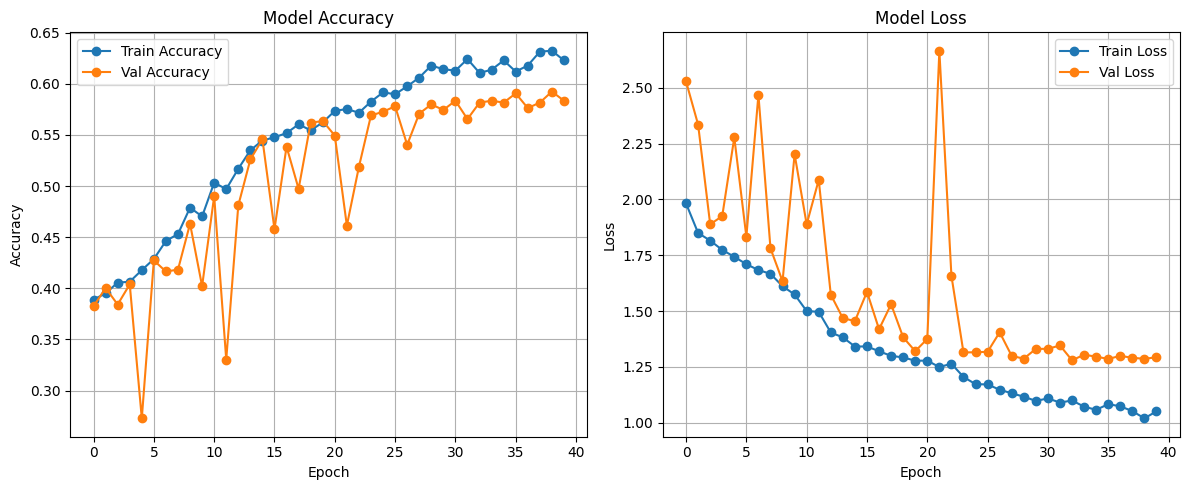

In [14]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.30      0.36      0.33        33
     Class 1       0.40      0.26      0.31        54
     Class 2       0.42      0.58      0.49        62
     Class 3       0.00      0.00      0.00         5
     Class 4       0.00      0.00      0.00        31
     Class 5       0.89      0.97      0.93       223
     Class 6       0.00      0.00      0.00         8
     Class 7       0.00      0.00      0.00        18
     Class 8       0.00      0.00      0.00         2
     Class 9       0.08      0.03      0.05        31
    Class 10       0.47      0.40      0.43        48
    Class 11       0.29      0.60      0.39        42

    accuracy                           0.58       557
   macro avg       0.24      0.27      0.24       557
weighted avg       0.53      0.58      0.55       557



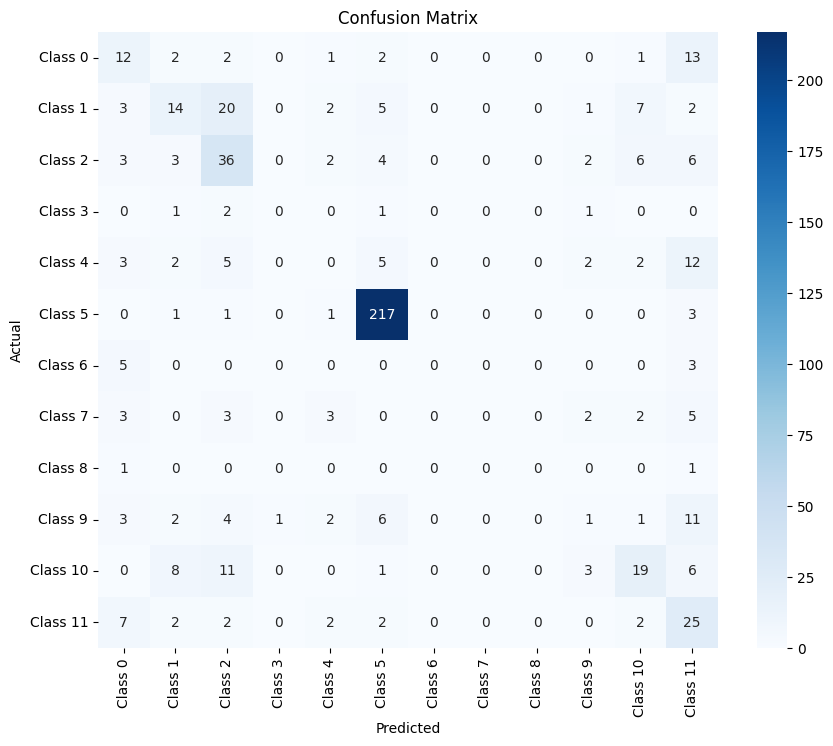

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
y_pred_prob = best_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Label names (replace with your actual class labels)
class_names = labels_encoder.classes_ if 'labels_encoder' in locals() else [f"Class {i}" for i in range(y_val.shape[1])]

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
